# Annotate the CLOUD library
Find targets for the 267 CLOUD drugs using 3 different databases  
a.) DrugBank  
b.) PubChem  
c.) ChEMBL

## DrugBank
Get drugs from the DrugBank-CLOUD subnetwork --> see GenerateDrugBankNetwork.py

In [3]:
import networkx as nx
import mygene

#Use MyGeneInfo to parse between different gene identifiers
mg = mygene.MyGeneInfo()

#Download Drugbank from https://www.drugbank.ca/releases/latest (version 5.1.2 used), then use 2a_Create_DrugBank_Network.ipynb to parse the xml file
DrugBankInfo = nx.read_gml('../data/Drug_Target_Annotations/Drugbank_2018-07-03_CLOUD_Only.gml')

Parse through the gml file for annotated targets (splitted in Targets, Transporters, Carriers, Enzymes)

In [4]:
#Dictionaries to save extrated DrugBank symbols/Ids
CLOUD_DrugBank_Symbols = {}
CLOUD_DrugBank_EntrezIDs = {}
CLOUD_DrugBank_Symbols_targetsOnly = {}
CLOUD_DrugBank_EntrezIDs_targetsOnly = {}
CLOUD_Name = {}



#Open CLOUD library overview file (contains CLOUD plus identifiers)
fp = open('../data/Drug_Target_Annotations/CLOUD_DrugBank_PubChem_Chembl.csv','r')
fp.next()

#Parse through all CLOUD drugs and check the DrugBank gml file for targets
for line in fp:
    
    tmp = line.strip().split(',')
    
    CLOUD_Name[tmp[0]] = tmp[4]
    
    #Dictionary for symbols and entrezIDs (all)
    CLOUD_DrugBank_Symbols[tmp[0]] = []
    CLOUD_DrugBank_EntrezIDs[tmp[0]] = []
    
    #Dictionary for symbols and entrezIDs (targets only)
    CLOUD_DrugBank_Symbols_targetsOnly[tmp[0]] = []
    CLOUD_DrugBank_EntrezIDs_targetsOnly[tmp[0]] = []
    
    
    #Get the raw DrugBank symbols (all)
    DrugBank_Target_Symbols = DrugBankInfo.node[tmp[1]]['Targets']
    DrugBank_Target_Symbols += ',' +DrugBankInfo.node[tmp[1]]['Enzymes']
    DrugBank_Target_Symbols += ',' +DrugBankInfo.node[tmp[1]]['Transporters']
    DrugBank_Target_Symbols += ',' +DrugBankInfo.node[tmp[1]]['Carriers']

    #Get the raw DrugBank symbols (targets only)
    DrugBank_Target_Symbols_targetsOnly = DrugBankInfo.node[tmp[1]]['Targets']
    
    
    #Parse separate drug target from role (e.g. inhibitor) (all)
    targets_roles = [x.strip().split('_') for x in DrugBank_Target_Symbols.split(',') if x != '']
    targets = []
    for t in targets_roles:
        targets.append(t[0])
        
        
    #Parse separate drug target from role (e.g. inhibitor) (all)
    targets_roles_targetsOnly = [x.strip().split('_') for x in DrugBank_Target_Symbols_targetsOnly.split(',') if x != '']
    targets_targetsOnly = []
    for t in targets_roles_targetsOnly:
        targets_targetsOnly.append(t[0])    
    
     
    #DrugBank only offers symbols, use mygeneinfo the get the corresponding entrezIDs (all)
    Symbols = []
    EntrezIDs = []
    for t in targets:
        try:
            query = mg.query(t, species='human')
            if query.has_key('hits'):
                ids = query['hits']
                if len(ids) > 0:
                    if ids[0]['symbol'] == t:
                        CLOUD_DrugBank_Symbols[tmp[0]].append(t)
                        CLOUD_DrugBank_EntrezIDs[tmp[0]].append(ids[0]['entrezgene'])
        except:
            print 'Problem with: %s' %t
            
    
    #DrugBank only offers symbols, use mygeneinfo the get the corresponding entrezIDs (all)
    Symbols_targetsOnly = []
    EntrezIDs_targetsOnly = []
    for t in targets_targetsOnly:
        try:
            query = mg.query(t, species='human')
            if query.has_key('hits'):
                ids = query['hits']
                if len(ids) > 0:
                    if ids[0]['symbol'] == t:
                        CLOUD_DrugBank_Symbols_targetsOnly[tmp[0]].append(t)
                        CLOUD_DrugBank_EntrezIDs_targetsOnly[tmp[0]].append(ids[0]['entrezgene'])
        except:
            print 'Problem with: %s' %t
    
    

fp.close()


# ##################
# Save the results #
# ##################

all_CLOUDS = CLOUD_DrugBank_EntrezIDs.keys()
all_CLOUDS.sort()

fp_out = open('../results/Drug_Target_Annotations/CLOUD_DrugBank_Targets.csv','w')
fp_out.write('CLOUD,Name,EntrezIDs,Symbols\n')

fp_out2 = open('../results/Drug_Target_Annotations/CLOUD_DrugBank_Targets_ONLY.csv','w')
fp_out2.write('CLOUD,Name,EntrezIDs,Symbols\n')
for cloud in all_CLOUDS:
    fp_out.write(cloud+','+CLOUD_Name[cloud]+','+';'.join([str(x) for x in CLOUD_DrugBank_EntrezIDs[cloud]])+','+';'.join(CLOUD_DrugBank_Symbols[cloud]) +'\n')
    fp_out2.write(cloud+','+CLOUD_Name[cloud]+','+';'.join([str(x) for x in CLOUD_DrugBank_EntrezIDs_targetsOnly[cloud]])+','+';'.join(CLOUD_DrugBank_Symbols_targetsOnly[cloud]) +'\n')
fp_out.close()
fp_out2.close()
print 'Finished finding DrugBank targets'

TypeError: sequence item 0: expected string, int found

## PubChem
Use the REST service of pubchem to find targets for given drugs; Use the pubchem supported significance

In [3]:
import urllib2
import mygene

mg = mygene.MyGeneInfo()

In [4]:
def getresult(url):
    '''
    Short function to get json from the PubChem webpage
    '''
    try:
        connection = urllib2.urlopen(url)
    except urllib2.HTTPError, e:
        return ""
    else:
        return connection.read().rstrip()

In [5]:
#Open CLOUD library overview file (contains CLOUD plus identifiers)
fp = open('../data/Drug_Target_Annotations/CLOUD_DrugBank_PubChem_Chembl.csv', 'r')
fp.next()

#Dictionaries to save extrated pubchem symbols/Ids
CLOUD_PubChem_Symbols = {}
CLOUD_PubChem_EntrezIDs = {}

#Parse through all CLOUD drugs
for line in fp:
    
    tmp = line.strip().split(',')
    
    PubChem_ID = tmp[2]
    CLOUD_PubChem_Symbols[tmp[0]] = []
    CLOUD_PubChem_EntrezIDs[tmp[0]] = []
    CLOUD_Name[tmp[0]] = tmp[4]
    
    #Find all assays for a given PubchemID
    #Extract then all activities --> Filter for active results
    pubChemResults = getresult('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/%d/assaysummary/CSV' %int(PubChem_ID))
    activities = pubChemResults.split('\n')
    geneIDs = set()
    tests = set()
    for element in activities[1:]:
        tmp2 = element.split(',')

        if tmp2[6] == '"Active"' and tmp2[8] != '""':
            geneIDs.add(int(tmp2[8]))
            tests.add(tmp2[10])

    #After extracting entrezIDs not reversly find the corresponding symbol
    query = mg.querymany(geneIDs, scope='entrezgene', species='human',verbose=False)

    for result in query:
        if result.has_key('symbol'):
            CLOUD_PubChem_Symbols[tmp[0]].append(result['symbol'])
            CLOUD_PubChem_EntrezIDs[tmp[0]].append(str(result['_id']))         
fp.close()

# ##################
# Save the results #
# ##################

fp_out = open('../results/Drug_Target_Annotations/CLOUD_PubChem_Targets.csv','w')
fp_out.write('CLOUD,Name,EntrezIDs,Symbols\n')
for cloud in all_CLOUDS:
    fp_out.write(cloud+','+CLOUD_Name[cloud]+','+';'.join(CLOUD_PubChem_EntrezIDs[cloud])+','+';'.join(CLOUD_PubChem_Symbols[cloud]) +'\n')
fp_out.close()

print 'Finished finding PubChem targets'

CLOUD001
CLOUD002
CLOUD003
CLOUD004
CLOUD005
CLOUD006
CLOUD007
CLOUD008
CLOUD009
CLOUD010
CLOUD011
CLOUD012
CLOUD013
CLOUD014
CLOUD015
CLOUD016
CLOUD017
CLOUD018
CLOUD019
CLOUD020
CLOUD021
CLOUD022
CLOUD023
CLOUD024
CLOUD025
CLOUD026
CLOUD027
CLOUD028
CLOUD029
CLOUD030
CLOUD031
CLOUD032
CLOUD033
CLOUD034
CLOUD035
CLOUD036
CLOUD037
CLOUD038
CLOUD039
CLOUD040
CLOUD041
CLOUD042
CLOUD043
CLOUD044
CLOUD045
CLOUD046
CLOUD047
CLOUD048
CLOUD049
CLOUD050
CLOUD051
CLOUD052
CLOUD053
CLOUD054
CLOUD055
CLOUD056
CLOUD057
CLOUD058
CLOUD059
CLOUD060
CLOUD061
CLOUD062
CLOUD063
CLOUD064
CLOUD065
CLOUD066
CLOUD067
CLOUD068
CLOUD069
CLOUD070
CLOUD071
CLOUD072
CLOUD073
CLOUD074
CLOUD075
CLOUD076
CLOUD077
CLOUD078
CLOUD079
CLOUD080
CLOUD081
CLOUD082
CLOUD083
CLOUD084
CLOUD085
CLOUD086
CLOUD087
CLOUD088
CLOUD089
CLOUD090
CLOUD091
CLOUD092
CLOUD093
CLOUD094
CLOUD095
CLOUD096
CLOUD097
CLOUD098
CLOUD099
CLOUD100
CLOUD101
CLOUD102
CLOUD103
CLOUD104
CLOUD105
CLOUD106
CLOUD107
CLOUD108
CLOUD109
CLOUD110
CLOUD111
C

## ChEMBL

In [6]:
import urllib2
import mygene
import json

mg = mygene.MyGeneInfo()

In [7]:
def getresult(url):
    '''
    Short function to get json from the PubChem webpage
    '''
    try:
        connection = urllib2.urlopen(url)
    except urllib2.HTTPError, e:
        return ""
    else:
        return connection.read().rstrip()

In [10]:
#Dictionaries to save extrated ChEMBL symbols/Ids
CLOUD_ChEMBL_Symbols = {}
CLOUD_ChEMBL_EntrezIDs = {}

#Cutoff (in uM) for activity
cutoff = 10.0

#allowed result types
allowed_Types = ['IC50','Ki','EC50']

#Open CLOUD library overview file (contains CLOUD plus identifiers)
fp = open('../data/Drug_Target_Annotations/CLOUD_DrugBank_PubChem_Chembl.csv', 'r')
fp.next()

#Parse through all CLOUD drugs
for line in fp:
    tmp = line.strip().split(',')
    
    chembl = tmp[3]
    
    CLOUD_ChEMBL_Symbols[tmp[0]] = []
    CLOUD_ChEMBL_EntrezIDs[tmp[0]] = []
    CLOUD_Name[tmp[0]] = tmp[4]
    

    #################################
    #Get the annotated targets (ON Targets)
    ################################
    
    #Get the ON Targets (characterized being found under the mechanism page)
    onTargets = []
    got_data = False
    while got_data == False
    try:
        data = getresult('https://www.ebi.ac.uk/chembl/api/data/mechanism?molecule_chembl_id=' + chembl + '&limit=1000&format=json')
        Drug_Data = json.loads(data)
        got_data = True
    except:
        print 'Error'

    if Drug_Data.has_key('mechanisms'):
        for mechanism in Drug_Data['mechanisms']:
            if mechanism['target_chembl_id'] != None:
                onTargets.append(mechanism['target_chembl_id'])
    
    got_data = False
    while got_data == False
    try:
        data = getresult('https://www.ebi.ac.uk/chembl/api/data/target?target_chembl_id__in=' + ','.join(onTargets) + '&format=json')
        Target_Data = json.loads(data)
        got_data = True
    except:
        print 'Error'
    
    #Parse through all targets that are of human origin (discard e.g. bacterial targets)
    uniprot_IDs = []
    for target in Target_Data['targets']:
        if target['tax_id'] ==  9606:
            if len(target['target_components']) > 0:
                uniprot_IDs.append(target['target_components'][0]['accession'])

    #Parse from Uniprot to entrezID and symbols
    query = mg.querymany(uniprot_IDs, scope='uniprot', species='human', verbose=False)

    for result in query:
        if result.has_key('symbol'):
            CLOUD_ChEMBL_Symbols[tmp[0]].append(result['symbol'])
            CLOUD_ChEMBL_EntrezIDs[tmp[0]].append(str(result['_id'])) 

            
    #################################
    #Get the remaining active targets (OFF Targets)
    ################################
    
    #Find all assay results for a given chembl ID
    got_data = False
    while got_data == False
    try:
        data = getresult('https://www.ebi.ac.uk/chembl/api/data/activity?molecule_chembl_id='+chembl+'&target_tax_id=9606&assay_type=B&limit=1000&format=json')
        Drug_Data = json.loads(data)
        got_data = True
    except:
        print 'Error'
    
    #Go through Mata information to find actual activities
    continueFlag = True
    while Drug_Data['page_meta']['next'] != None and continueFlag:
        data = getresult('https://www.ebi.ac.uk'+Drug_Data['page_meta']['next'])
        Drug_Data_NextPage = json.loads(data)

        if Drug_Data_NextPage['page_meta']['next'] != None:
            continueFlag = True
        else:
            continueFlag = False

        Drug_Data['activities'].extend(Drug_Data_NextPage['activities'])

    
    #Find only active results 
    active = set()
    not_active = set()
    for act in Drug_Data['activities']:
        if act['standard_type'] in allowed_Types:
            try:
                value = act['published_value']
                unit = act['units']

                if (unit == 'pM' and float(value) < cutoff * 1000000) or (unit == 'nM' and float(value) < cutoff * 1000) or (unit == 'uM' and float(value) < cutoff) or (unit == 'mM' and float(value) < cutoff/1000) or (unit == 'M' and float(value) < cutoff/1000000):
                    active.add(act['target_chembl_id'])
                else:
                    not_active.add(act['target_chembl_id'])
            except:
                continue
    
    #Extract the uniport target identifiers
    got_data = False
    while got_data == False
    try:
        data = getresult('https://www.ebi.ac.uk/chembl/api/data/target?target_chembl_id__in='+','.join(list(active))+'&format=json')
        Target_Data = json.loads(data)
        got_data = True
    except:
        print 'Error'
                
    uniprot_IDs = []
    for target in Target_Data['targets']:
        if target['tax_id'] == 9606:
            if len(target['target_components']) > 0:
                uniprot_IDs.append(target['target_components'][0]['accession'])

    #Parse from uniprot to entrezID and symbol
    query = mg.querymany(uniprot_IDs,scope='uniprot',species='human',verbose=False)

    for result in query:
        if result.has_key('symbol'):
            CLOUD_ChEMBL_Symbols[tmp[0]].append(result['symbol'])
            CLOUD_ChEMBL_EntrezIDs[tmp[0]].append(str(result['_id']))
    
fp.close()


# ##################
# Save the results #
# ##################


fp_out = open('../results/Drug_Target_Annotations/CLOUD_ChEMBL_Targets.csv','w')
fp_out.write('CLOUD,Name,EntrezIDs,Symbols\n')
for cloud in all_CLOUDS:
    fp_out.write(cloud+','+CLOUD_Name[cloud]+','+';'.join(CLOUD_ChEMBL_EntrezIDs[cloud])+','+';'.join(CLOUD_ChEMBL_Symbols[cloud]) +'\n')
fp_out.close()

print 'Finished finding ChEMBL targets'

CLOUD001
CLOUD002
CLOUD003
CLOUD004
CLOUD005
CLOUD006
CLOUD007
CLOUD008
CLOUD009
CLOUD010
CLOUD011
CLOUD012
CLOUD013
CLOUD014
CLOUD015
CLOUD016
CLOUD017
CLOUD018
CLOUD019
CLOUD020
CLOUD021
CLOUD022
CLOUD023
CLOUD024
CLOUD025
CLOUD026
CLOUD027
CLOUD028
CLOUD029
CLOUD030
CLOUD031
CLOUD032
CLOUD033
CLOUD034
CLOUD035
CLOUD036
CLOUD037
CLOUD038
CLOUD039
CLOUD040
CLOUD041
CLOUD042
CLOUD043
CLOUD044
CLOUD045
CLOUD046
CLOUD047
CLOUD048
CLOUD049
CLOUD050
CLOUD051
CLOUD052
CLOUD053
CLOUD054
CLOUD055
CLOUD056
CLOUD057
CLOUD058
CLOUD059
CLOUD060
CLOUD061
CLOUD062
CLOUD063
CLOUD064
CLOUD065
CLOUD066
CLOUD067
CLOUD068
CLOUD069
CLOUD070
CLOUD071
CLOUD072
CLOUD073
CLOUD074
CLOUD075
CLOUD076
CLOUD077
CLOUD078
CLOUD079
CLOUD080
CLOUD081
CLOUD082
CLOUD083
CLOUD084
CLOUD085
CLOUD086
CLOUD087
CLOUD088
CLOUD089
CLOUD090
CLOUD091
CLOUD092
CLOUD093
CLOUD094
CLOUD095
CLOUD096
CLOUD097
CLOUD098
CLOUD099
CLOUD100
CLOUD101
CLOUD102
CLOUD103
CLOUD104
CLOUD105
CLOUD106
CLOUD107
CLOUD108
CLOUD109
CLOUD110
CLOUD111
C

## Create Final List of Targets
Create a final list that contains all targets from all sources combined

In [11]:
#dictionary containing all found targets for a given drug
CLOUD_Combined_EntrezIDs = {}

#parse through all drugs and find targets from the different source; create output file
fp_out = open('../results/Drug_Target_Annotations/CLOUD_All_Targets.csv','w')
fp_out.write('CLOUD,Name,EntrezIDs,Symbols\n')
for cloud in all_CLOUDS:
    targets = list(CLOUD_DrugBank_EntrezIDs[cloud])
    
    for t in CLOUD_PubChem_EntrezIDs[cloud]:
        if t not in targets:
            targets.append(t)
    
    for t in CLOUD_ChEMBL_EntrezIDs[cloud]:
        if t not in targets:
            targets.append(t)
   
    
    symbols = list(CLOUD_DrugBank_Symbols[cloud])
    for t in CLOUD_PubChem_Symbols[cloud]:
        if t not in targets:
            symbols.append(t)
    
    for t in CLOUD_ChEMBL_Symbols[cloud]:
        if t not in targets:
            symbols.append(t)
    
    CLOUD_Combined_EntrezIDs[cloud] = targets
    
    fp_out.write(cloud+','+CLOUD_Name[cloud]+','+';'.join(targets)+','+';'.join(symbols) +'\n')
fp_out.close()
print 'Finished Creating Final CLOUD target list'

Finished Creating Final CLOUD target list


## Check Drug Target Annotation
Check the individual sources for mean, median, total amound of targets found

In [2]:
import numpy as np

targets_DrugBank = []
counts_DrugBank = []
for c in all_CLOUDS:
    targets_DrugBank.extend(CLOUD_DrugBank_EntrezIDs[c])
    counts_DrugBank.append(len(CLOUD_DrugBank_EntrezIDs[c]))
    
print 'DrugBank:'
print '\tTotal amount of targets: %d' %len(targets_DrugBank)
print '\tAmount of distinct targets: %d' %len(set(targets_DrugBank))
print '\tMean targets: %.2f' %np.mean(counts_DrugBank)
print '\tMedian targets: %.2f' %np.median(counts_DrugBank)

targets_PubChem = []
counts_PubChem = []
for c in all_CLOUDS:
    targets_PubChem.extend(CLOUD_PubChem_EntrezIDs[c])
    counts_PubChem.append(len(CLOUD_PubChem_EntrezIDs[c]))
    
print 'PubChem:'
print '\tTotal amount of targets: %d' %len(targets_PubChem)
print '\tAmount of distinct targets: %d' %len(set(targets_PubChem))
print '\tMean targets: %.2f' %np.mean(counts_PubChem)
print '\tMedian targets: %.2f' %np.median(counts_PubChem)

targets_ChEMBL = []
counts_ChEMBL = []
for c in all_CLOUDS:
    targets_ChEMBL.extend(CLOUD_ChEMBL_EntrezIDs[c])
    counts_ChEMBL.append(len(CLOUD_ChEMBL_EntrezIDs[c]))
    
print 'ChEMBL:'
print '\tTotal amount of targets: %d' %len(targets_ChEMBL)
print '\tAmount of distinct targets: %d' %len(set(targets_ChEMBL))
print '\tMean targets: %.2f' %np.mean(counts_ChEMBL)
print '\tMedian targets: %.2f' %np.median(counts_ChEMBL)


targets_combined = []
counts_combined = []
for c in all_CLOUDS:
    targets_combined.extend(CLOUD_Combined_EntrezIDs[c])
    counts_combined.append(len(CLOUD_Combined_EntrezIDs[c]))
    
print '\nCombined:'
print '\tTotal amount of targets: %d' %len(targets_combined)
print '\tAmount of distinct targets: %d' %len(set(targets_combined))
print '\tMean targets: %.2f' %np.mean(counts_combined)
print '\tMedian targets: %.2f' %np.median(counts_combined)

NameError: name 'all_CLOUDS' is not defined

### Read results files

In [5]:
targets_DrugBank = []
targets_ChEMBL = []
targets_PubChem = []

fp = open('../results/Drug_Target_Annotations/CLOUD_DrugBank_Targets.csv')
fp.next()
for line in fp:
    tmp = line.strip().split(',')
    targets_DrugBank.extend(tmp[2].split(';'))
    
fp = open('../results/Drug_Target_Annotations/CLOUD_ChEMBL_Targets.csv')
fp.next()
for line in fp:
    tmp = line.strip().split(',')
    targets_ChEMBL.extend(tmp[2].split(';'))
    
fp = open('../results/Drug_Target_Annotations/CLOUD_PubChem_Targets.csv')
fp.next()
for line in fp:
    tmp = line.strip().split(',')
    targets_PubChem.extend(tmp[2].split(';'))

Create a Venn Diagram to show the overlap between the data sources

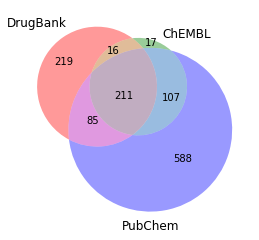

In [7]:
# libraries
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
 
#Create a triple Venn Diagram
venn3([set(targets_DrugBank), set(targets_ChEMBL),set(targets_PubChem)], set_labels = ('DrugBank', 'ChEMBL','PubChem'))
#plt.show()
plt.savefig('../results/Drug_Target_Annotations/Database_Overlap.pdf')


In [3]:
plt.hist(counts_combined,bins='auto',color='#D2323C')
plt.axvline(np.mean(counts_combined), ls ='--', color = 'grey')
plt.xlabel('Number of Targets')
plt.ylabel('Number of Drugs')
plt.savefig('../results/Drug_Target_Annotations/Amount_Targets')
plt.close

NameError: name 'counts_combined' is not defined